In [1]:
from PIL import Image
import scipy as sp
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
""" Image Preprocessing
Our goal here is to create a sparse matrix of shape (# pixels, 3) where
each row represents each pixel (ordered row wise) and each column repr-
-esents each of R,G,B values.
"""
image = Image.open('/content/test_image3.png').convert('RGB')
image_array = np.array(image).reshape(-1, 3)
# Make it sparse
sp_image_array = sp.sparse.csr_matrix(image_array)

In [46]:
""" Spectral Clustering
"""
spec = SpectralClustering(n_clusters = 3, eigen_solver='arpack', affinity='rbf', gamma=0.001)
pred = spec.fit_predict(image_array)

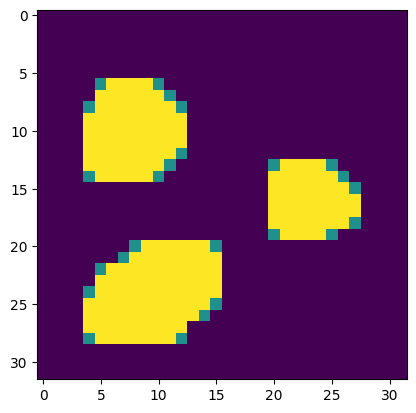

In [47]:
plt.imshow(pred.reshape(32,32))